# Data Wrangling

Download labels from: http://www.tamaraberg.com/street2shop/wheretobuyit/  
Paper: http://www.cs.unc.edu/~xufeng/cs/papers/iccv15-wheretobuyit.pdf

This dataset contains exact street2shop pairs and the retrieval sets for 11 clothing categories: bags, belts, dresses, eyewear, footwear, hats, leggings, outerwear, pants, skirts, tops

"To study Exact Street to Shop at large scale, we collected and labeled a dataset of 20,357 images of clothing worn by
people in the real world,  and 404,483 images of clothing from shopping websites.  The dataset contains 39,479 pairs
of exactly matching items worn in street photos and shown in shop images."  
  
  
*M. Hadi Kiapour, Xufeng Han, Svetlana Lazebnik, Alexander C. Berg, Tamara L. Berg. Where to Buy It: Matching Street Clothing Photos in Online Shops. International Conference on Computer Vision (ICCV), 2015.*

**For this project all images have already been downloaded and resized. Due to some broken links the final number of images retrieved is 383,169**

In [1]:
import os
import re
import random
import pandas as pd
import numpy as np
from PIL import Image
import sys
import joblib #save/load objects
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
import shutil
%matplotlib inline
plt.style.use('seaborn-notebook')
pd.options.mode.chained_assignment = None  #disables .loc assignment warning

Files are separated into 3 classes: retrieval, train and test, this is done so the original paper can be replicated which is not the purpose of this project. Each of these classes have a json for each of the 11 clothing categories.  

The function below merges all categories json files under the 3 classes, then train and test are also merged so we can do our own custom data split.

In [2]:
path_labels = "../labels"
json_files = os.listdir(path_labels)
print("Starting labels structure:")
json_files

Starting labels structure:


['.gitkeep',
 'retrieval_bags.json',
 'retrieval_belts.json',
 'retrieval_dresses.json',
 'retrieval_eyewear.json',
 'retrieval_footwear.json',
 'retrieval_hats.json',
 'retrieval_leggings.json',
 'retrieval_outerwear.json',
 'retrieval_pants.json',
 'retrieval_skirts.json',
 'retrieval_tops.json',
 'test_pairs_bags.json',
 'test_pairs_belts.json',
 'test_pairs_dresses.json',
 'test_pairs_eyewear.json',
 'test_pairs_footwear.json',
 'test_pairs_hats.json',
 'test_pairs_leggings.json',
 'test_pairs_outerwear.json',
 'test_pairs_pants.json',
 'test_pairs_skirts.json',
 'test_pairs_tops.json',
 'train_pairs_bags.json',
 'train_pairs_belts.json',
 'train_pairs_dresses.json',
 'train_pairs_eyewear.json',
 'train_pairs_footwear.json',
 'train_pairs_hats.json',
 'train_pairs_leggings.json',
 'train_pairs_outerwear.json',
 'train_pairs_pants.json',
 'train_pairs_skirts.json',
 'train_pairs_tops.json']

In [3]:
def format_labels(path_labels, store_images=False):
    """formats original jsons into either retrival set or customer set"""
    
    json_files = os.listdir(path_labels)
    json_files = [os.path.join(path_labels, file) for file in json_files] #reading in all json files
    if store_images==False:
        all_files = [file for file in json_files if "retrieval" in file]
    else:
        all_files = [file for file in json_files if ("train" in file) | ("test" in file)]
    
    files_df = pd.DataFrame() #appending all retrieval / customer into a dataframe
    for file in all_files:
        files_df = files_df.append(pd.read_json(file))
    
    category_files = [file.split("_")[-1].split(".json")[0] for file in all_files] #finding category file
    category_nrows = [pd.read_json(file).shape[0] for file in all_files] #finding number of rows for each file
    
    files_df["category"] = ""
    for n, category in enumerate(category_files):
        if n == 0:
            files_df["category"].iloc[0:category_nrows[0]] = category
        index_0 = sum(category_nrows[:n])
        index_1 = sum(category_nrows[:n+1])
        files_df["category"].iloc[index_0:index_1] = category
    files_df = files_df.reset_index(drop=True)
    
    files_df["id"] = files_df["product"].astype(str) + "_" + files_df["category"] #creating key for pair matching

    if store_images == True: #fixing format of bboxes, originally a dictionary within a column
        files_df["bbox"] = files_df["bbox"].apply(lambda x: {k:v for k, v in sorted(x.items())}) #fixes missalignment in label order
        files_df["bbox"] = files_df["bbox"].apply(lambda x: "".join(map(lambda x: str(x) + ",", list(x.values()))))

        bboxes = files_df["bbox"].str.split(",",expand=True).drop(columns=[4])
        bboxes.columns=(["height", "left", "top", "width"])
        files_df = pd.concat([files_df,bboxes], axis=1).drop(columns=["bbox"])
        return files_df
    return files_df

In [4]:
retrieval_df = format_labels(path_labels)
customer_df = format_labels(path_labels, store_images=True)

In [5]:
retrieval_df.head(3)

,photo,product,category,id
0,75161,1,bags,1_bags
1,75162,1,bags,1_bags
2,249331,2,bags,2_bags


In [6]:
customer_df.head(3)

,photo,product,category,id,height,left,top,width
0,4534,7419,bags,7419_bags,358,134,172,120
1,16159,9946,bags,9946_bags,303,148,184,120
2,6538,10777,bags,10777_bags,88,100,310,57


## Retrieval: Images without a blank background

After performing a visual check of the photos downloaded we realised that some of the retrieval images are not useful for the purpose of this project as they are are not consistent with the majority of retrieval images, ie. images from magazines, photos from customer that have been used as retrieval, or close-ups of fabric and patterns from a piece of clothing.  

These can be easily identified due to not having a blank background. Examples shown below.

This is particularly challenging since the dataset is constructed by taking images from more than 10 different online shopping retailers each of them having their own photography style for their products.

In [7]:
img_path = "../photos_resized/"
example_img = "19472.jpg"
example_img_2 = "89745.jpg"
example_img_wrong = "19591.jpg"
example_img_wrong_2 = "97569.jpg"
example_images = [example_img, example_img_2, example_img_wrong, example_img_wrong_2]

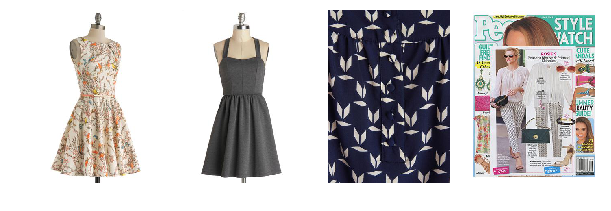

In [8]:
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(1, len(example_images))

for n, i in enumerate(example_images):
    ax = fig.add_subplot(gs[0, n])
    ax.imshow(Image.open(img_path+i))
    ax.axis("off")
plt.show()

Images "19591.jpg" and 97569 were spotted as examples, so we will proceed to look for more images like this one and remove them from the sets.

In order to find these images the strategy we will follow will be to read every image in the folder and extract a small rectangle composed of the first 10x100 pixels with its numeric representation, we will then aggregate the resulting array and compare it to the array of a correct example.

In [9]:
def square_sample(img_path, img, x, y):
    """
    This function allows us to select a region of the image we want to convert to an array
    Just specify the x and y coordinates in a list format i.e x=[0,10], y=[0,10]
    """
    img_read = cv2.imread(img_path+img)
    img_sum = 0

    for line in img_read[y[0]:y[1]]:
        img_sum += line[x[0]:x[1]].sum()
        
    return img_sum

In [10]:
print("Sum of the first 10*100 pixels of the image:")
print("Correct_img_1", square_sample(img_path, example_img, [0,10], [0,100]))
print("Correct_img_2", square_sample(img_path, example_img_2, [0,10], [0,100]))
print("Wrong_img    ", square_sample(img_path, example_img_wrong, [0,10], [0,100]))

threshold = 700000

Sum of the first 10*100 pixels of the image:
Correct_img_1 765000
Correct_img_2 764751
Wrong_img     202833


Images 1 and 2 are both correct, however the sum of the elements of the second one are slightly different. This could be caused by a very light grey pixel, therefore we have decided to use 700,000 as a threshold so it gives a little bit of margin when filtering images. Any sum of elements below this threshold will be classified as a wrong image.

In [11]:
# read images and sort them in alphanumeric
list_pics = os.listdir(img_path)
list_pics = sorted(list_pics, key = lambda x: int(re.sub("(\\D)", "", x)))

# we only need to read retrieval images
mask_retr = pd.Series(list_pics).isin(retrieval_df['photo'].map(lambda x: str(x)+".jpg"))
list_pics = np.array(list_pics)[mask_retr]

In [12]:
def read_imgs(img_path, list_pics, x, y):
    """
    Return an array with the sum of the elements of each image
    """
    img_arrays = []
    with tqdm(total=len(list_pics), file=sys.stdout) as pbar:
        for n, img in enumerate(list_pics):
            img_sum = square_sample(img_path, img, x=x, y=y)
            img_arrays.append(img_sum)
            pbar.set_description("done: %d" % (1 + n))
            pbar.update(1)
    return np.array(img_arrays)

The function to read all images takes around 20 min to complete. To avoid waiting such a long time please load the *.pkl  object with the resulting array that has been previously saved.

In [13]:
%%time
imgs_sum_wrong = read_imgs(img_path, list_pics, [0,10], [0,100])
joblib.dump(imgs_sum_wrong, "./pkl_objects/imgs_sum_wrong.pkl")


Wall time: 25min 20s


In [13]:
imgs_sum_wrong = joblib.load("./pkl_objects/imgs_sum_wrong.pkl")

In [14]:
wrong_images = list_pics[imgs_sum_wrong < threshold]
print("Retrieval")
print("Total images:", len(imgs_sum_wrong))
print("Wrong images:", len(wrong_images))

Retrieval
Total images: 362812
Wrong images: 41688


After identifying all wrong images we will copy a sample of them into a new folder for a quick visual exploration to ensure that no correct images are deleted.

In [15]:
img_path_check = "../photos_check"
os.makedirs(img_path_check, exist_ok=True)

In [16]:
sample = 1000
wrong_sample = [random.choice(wrong_images) for i in range(sample)]

for img in tqdm(wrong_sample):
    shutil.copy(os.path.join(img_path, img), os.path.join(img_path_check, img))

Once we are confident of excluding these wrong images we will save them in a list without the *.jpg extension so they can be removed from the retrieval dataframe

In [17]:
shutil.rmtree(img_path_check, ignore_errors=True) # removing temporary folder
wrong_images = [img.split('.')[0] for img in wrong_images]

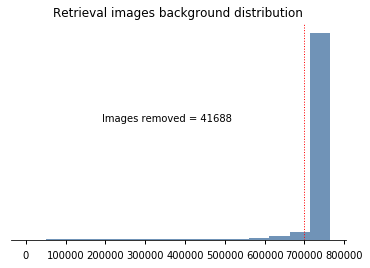

In [18]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.set_facecolor('white')
ax.hist(imgs_sum_wrong, bins=15, color=(0.2, 0.4, 0.6, 0.7))
ax.axvline(x=threshold, c='r', linestyle=":", linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.text(s='Images removed = '+str(len(wrong_images)), x=imgs_sum_wrong.max()/4, y=len(imgs_sum_wrong)/2)
ax.get_yaxis().set_visible(False)
ax.set_title("Retrieval images background distribution")
plt.show()

## Retrieval: Empty images

We have also identified that some images are jpg placeholders and show the message "Image Not Available". We will refer to them as "empty images".

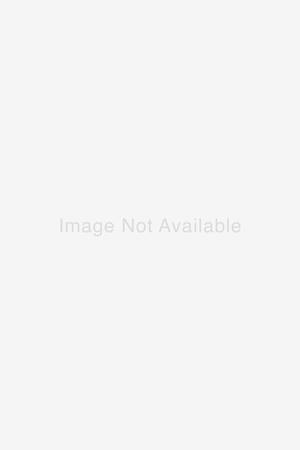

In [19]:
empty_img = "192741.jpg"
Image.open(img_path+empty_img)

Image "192741.jpg" was spotted as an example, so we will proceed to look for more images like this one and remove them from the sets. These images come from corrupted links when retrieving images from stores.  

We will follow the same strategy as before, but in this case the threshold will be the exact number of the sum of the pixels as we want to find all same images.

In [20]:
print("Sum of 20*20 pixels from the centre of the image:")
print("Empty_img ", square_sample(img_path, empty_img, [140,160], [220,240]))

threshold = square_sample(img_path, empty_img, [140,160], [220,240])

Sum of 20*20 pixels from the centre of the image:
Empty_img  290007


In [21]:
%%time 
# ~20 min to run. Please load the pkl object below

imgs_sum_empty = read_imgs(img_path, list_pics, [140,160], [220,240])
joblib.dump(imgs_sum_empty, "./pkl_objects/imgs_sum_empty.pkl")


Wall time: 25min 51s


In [22]:
imgs_sum_empty = joblib.load("./pkl_objects/imgs_sum_empty.pkl")

In [23]:
empty_images = np.array(list_pics)[imgs_sum_empty == threshold]
print("Number of blank images:", len(empty_images))

Number of blank images: 1354


In [24]:
empty_images = np.array(list_pics)[imgs_sum_empty == threshold]
print("Number of blank images:", len(empty_images))

Number of blank images: 1354


We will now copy all empty images to our "photos_check" folder for visual exploration

In [25]:
os.makedirs(img_path_check, exist_ok=True)

for img in tqdm(empty_images):
    shutil.copy(os.path.join(img_path, img), os.path.join(img_path_check, img))

Once we are confident of excluding these empty images we will save them in a list without the *.jpg extension so they can be removed from the retrieval dataframe

In [26]:
shutil.rmtree(img_path_check, ignore_errors=True) #delete temporary folder
empty_images = [img.split('.')[0] for img in empty_images]

## Clearing up label files
We will read all images in the folder with the intention to filter the labels from the images that have not been downloaded.
From the remaining labels we will then remove the data from the images that do not serve our purpose (wrong images) and the empty images.

In [27]:
all_images = os.listdir("../photos_resized")
all_images = [img.split(".")[0] for img in all_images]
print("Wrong images:  ", len(wrong_images))
print("Empty images:  ", len(empty_images))

Wrong images:   41688
Empty images:   1354


In [28]:
customer_df = customer_df[customer_df["photo"].isin(all_images)]
retrieval_df = retrieval_df[retrieval_df["photo"].isin(all_images)]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(wrong_images)]
retrieval_df = retrieval_df[~retrieval_df["photo"].isin(empty_images)]

Removing customer images that do not have a pair match since their actual matches may have been removed now

In [29]:
print("Total customer images: ", customer_df.shape[0])
customer_available = customer_df[customer_df["id"].isin(retrieval_df["id"])]
print("Total matches: ", customer_available.shape[0])

Total customer images:  39266
Total matches:  28180


To simplify potential scenarios we will also remove images in retrieval that are used for multiple categories. This removes labels from ~250 photos.

This kind of challenges will be further explored in the exploration notebook, however at this point the focus is on having the customer and retrieval csvs in their final version.

In [30]:
retrieval_df_2 = retrieval_df.drop_duplicates(subset=["photo"])

## Updating bounding boxes

Due to the resizing of the dataset we now need to update the original coordinates of the bounding boxes.  

Since the resizing parameters were fixed to width 300 and preserving the original aspect ratio, every image is unique in size. The "aspect_ratios.csv" file was created during the resizing procces and it contains the resize factor applied to each image in customer, we will use this file to update the coordinates.

In [31]:
customer_available.head(3)

,photo,product,category,id,height,left,top,width
0,4534,7419,bags,7419_bags,358,134,172,120
1,16159,9946,bags,9946_bags,303,148,184,120
2,6538,10777,bags,10777_bags,88,100,310,57


In [32]:
aspect_ratios = pd.read_csv("./aspect_ratios.csv")
aspect_ratios["img"] = aspect_ratios["img"].str.extract("(\d*)")
aspect_ratios["img"] = aspect_ratios["img"].astype(int)

customer_df = customer_available.merge(aspect_ratios, how="inner", left_on="photo",right_on="img").drop(columns=["img"])
customer_df = customer_df[customer_df["ratio"] != "corrupted"] #removing corrupted photos
customer_df["ratio"] = customer_df["ratio"].astype(float)

#updating bboxes coordinates
customer_df[["height", "left", "top", "width"]] = customer_df[["height", "left", "top", "width"]].astype(float).astype(int)
customer_df["height"] = customer_df["height"]*customer_df["ratio"]
customer_df["left"] = customer_df["left"]*customer_df["ratio"]
customer_df["top"] = customer_df["top"]*customer_df["ratio"]
customer_df["width"] = customer_df["width"]*customer_df["ratio"]

customer_df[["height", "left", "top", "width"]] = customer_df[["height", "left", "top", "width"]].round().astype(int)

customer_df.drop(columns=["ratio"], inplace=True)
customer_df.head(3)

,photo,product,category,id,height,left,top,width
0,4534,7419,bags,7419_bags,205,77,98,69
1,16159,9946,bags,9946_bags,172,84,104,68
2,6538,10777,bags,10777_bags,57,65,201,37


## Saving the final retrieval and customer csv files

In [33]:
retrieval_df.to_csv("retrieval_df.csv", index=False)
customer_df.to_csv("customer_df.csv", index=False)